# Deep learning - LSTM 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, RNN

import warnings
warnings.filterwarnings('ignore')

2024-04-09 12:38:27.274700: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [4]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
def format_timeseries_data(df, input_length, output_length, target_names):
    
    if target_names is not None:
        target_indices = {name: i for i, name in enumerate(target_names)}
    col_indices = {name: i for i, name in enumerate(df.columns)}
    
    total_length = input_length + output_length
    
    input_slice = slice(0, input_length)
    output_slice = slice(input_length, None)
    
    data = np.array(df, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=total_length,
        sequence_stride=1,
        shuffle=False,
        batch_size=32
    )
    
    def split_to_input_output(x):
            
        inputs = x[:, input_slice, :]
        outputs = x[:, output_slice, :]
        
        if target_names is not None:
            outputs = tf.stack(
                [outputs[:,:,col_indices[name]] for name in target_names],
                axis=-1
            )

        inputs.set_shape([None, input_length, None])
        outputs.set_shape([None, output_length, None])
    
        return inputs, outputs
    
    ds = ds.map(split_to_input_output)
    
    return ds

In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).__float__()
    
lr_scheduler = LearningRateScheduler(scheduler)

def train_model_old(model, train_ds, val_ds, patience=5, max_epochs=50, use_scheduler=False):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    
    history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])
    
    if use_scheduler == True:
        history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping, lr_scheduler])
    
    return history

def train_model(model, train_ds, val_ds, patience=5, max_epochs=50, use_scheduler=False):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    
    
    
    if use_scheduler == True:
        history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping, lr_scheduler])

    else:
        history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])
    
    return history

In [7]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend(loc='best')

    ax2.plot(history.history['mean_absolute_error'], label='Train')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Mean absolute error')
    ax2.legend(loc='best')

    plt.tight_layout()

In [8]:
def plot_predictions(model, sample_batch, model_type):
    
    inputs, outputs = sample_batch
    preds = model(inputs)
    
    if model_type == 'single_step':      

        fig, ax = plt.subplots()

        actual_scaled = outputs.numpy().flatten()
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train
        
        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_step':

        fig, ax = plt.subplots()
        
        actual_scaled = outputs.numpy().flatten()[:48]
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()[:48]
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_output':
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
        
        OT_actual_scaled = outputs.numpy().flatten()[0::2]
        OT_actual = OT_actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        OT_predictions_scaled = preds.numpy().flatten()[0::2]
        OT_predictions = OT_predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        MULL_actual_scaled = outputs.numpy().flatten()[1::2]
        MULL_actual = MULL_actual_scaled * (MULL_max_test - MULL_min_test) + MULL_min_test
        
        MULL_predictions_scaled = preds.numpy().flatten()[1::2]
        MULL_predictions = MULL_predictions_scaled * (MULL_max_train - MULL_min_train) + MULL_min_train
        
        ax1.plot(OT_actual, label='Actual')
        ax1.plot(OT_predictions, label='Predicted')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Oil temperature')
        ax1.legend(loc='best')
        ax1.set_title('Predictions on a sample batch')
        
        ax2.plot(MULL_actual, label='Actual')
        ax2.plot(MULL_predictions, label='Predicted')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('MULL')
        ax2.legend(loc='best')
        
    plt.tight_layout()

In [9]:
def plot_evaluation(model_list, mae):
    
    fig, ax = plt.subplots()
    
    ax.bar(model_list, mae, width=0.3)
    ax.set_ylabel('MAE')
    ax.set_xlabel('Models')
    ax.set_ylim(0, max(mae)+0.15)
    for index, value in enumerate(mae):
        ax.text(x=index, y=value+0.005, s=str(round(value, 3)), ha='center')
    
    plt.tight_layout()

In [10]:
MULL_max_train = 7.568999767303468
MULL_min_train = -5.934000015258789
MULL_max_test = 4.690999984741211
MULL_min_test = -3.3399999141693115

OT_max_train = 46.00699996948242
OT_min_train = -4.079999923706056
OT_max_test = 17.165000915527347
OT_min_test = 3.025000095367432

## Single-step model 

In [11]:
train_ds_ss = format_timeseries_data(train_df, 1, 1, ['OT'])
val_ds_ss = format_timeseries_data(val_df, 1, 1, ['OT'])
test_ds_ss = format_timeseries_data(test_df, 1, 1, ['OT'])

ss_sample_batch = next(iter(test_ds_ss))

In [12]:
# Create a single-step LSTM model
ss_lstm = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1)
])

ss_lstm_history = train_model(ss_lstm, train_ds_ss, val_ds_ss, use_scheduler=True)

Epoch 1/50


382/382 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1170 - mean_absolute_error: 0.2270 - val_loss: 0.0111 - val_mean_absolute_error: 0.0907 - learning_rate: 0.0010
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0130 - mean_absolute_error: 0.0873 - val_loss: 0.0033 - val_mean_absolute_error: 0.0434 - learning_rate: 0.0010
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0659 - val_loss: 0.0052 - val_mean_absolute_error: 0.0586 - learning_rate: 9.0484e-04
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0689 - val_loss: 0.0077 - val_mean_absolute_error: 0.0711 - learning_rate: 8.1873e-04
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - mean_absolute_error: 0.0819 - val_loss: 0.0037 - val_mean_absolute_error: 0.0476 - learning_rate: 7.4082e-04
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0123 - mean_absolute_error: 0.0819 - val_loss: 0.0020 - val_mean_ab

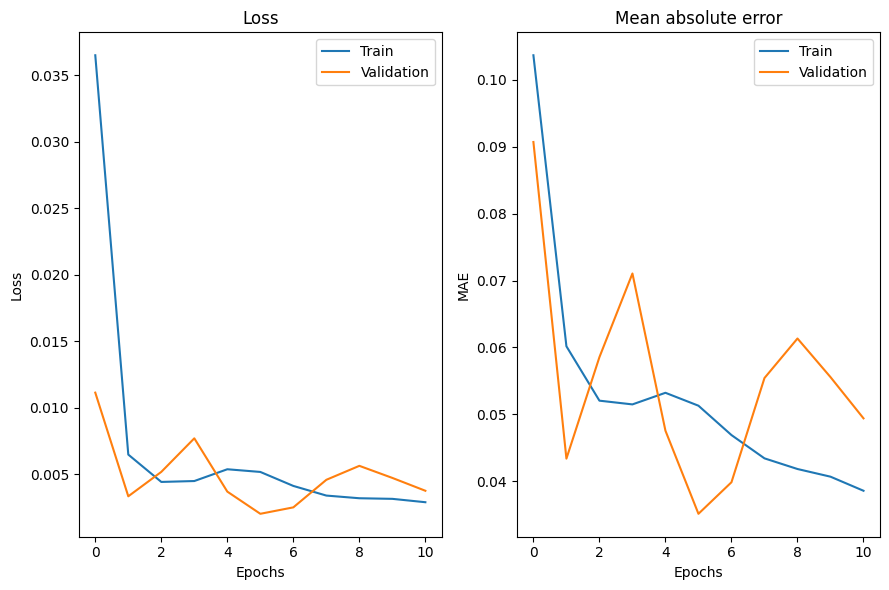

In [13]:
plot_history(ss_lstm_history)

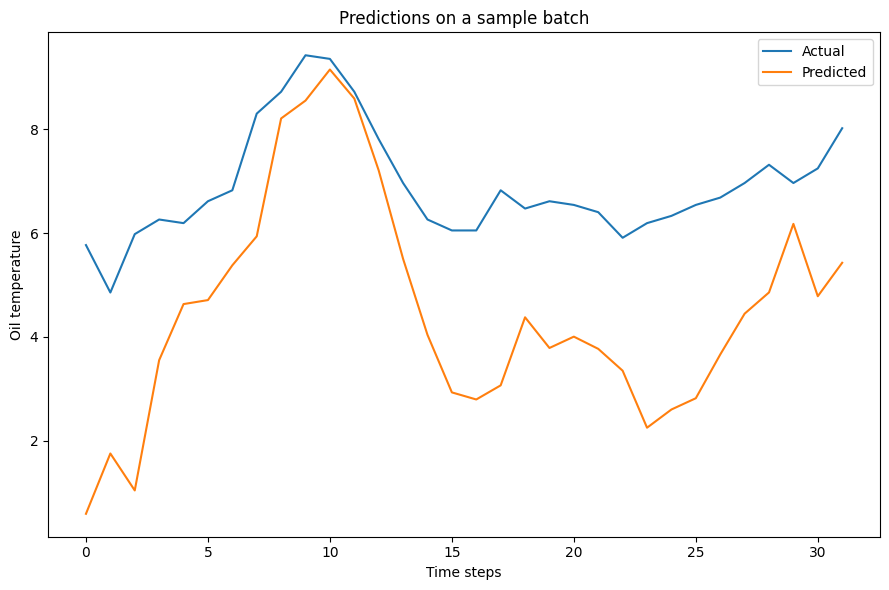

In [14]:
plot_predictions(ss_lstm, ss_sample_batch, 'single_step')

### Evaluation 

 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0124 - mean_absolute_error: 0.1036

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0338 - mean_absolute_error: 0.1625


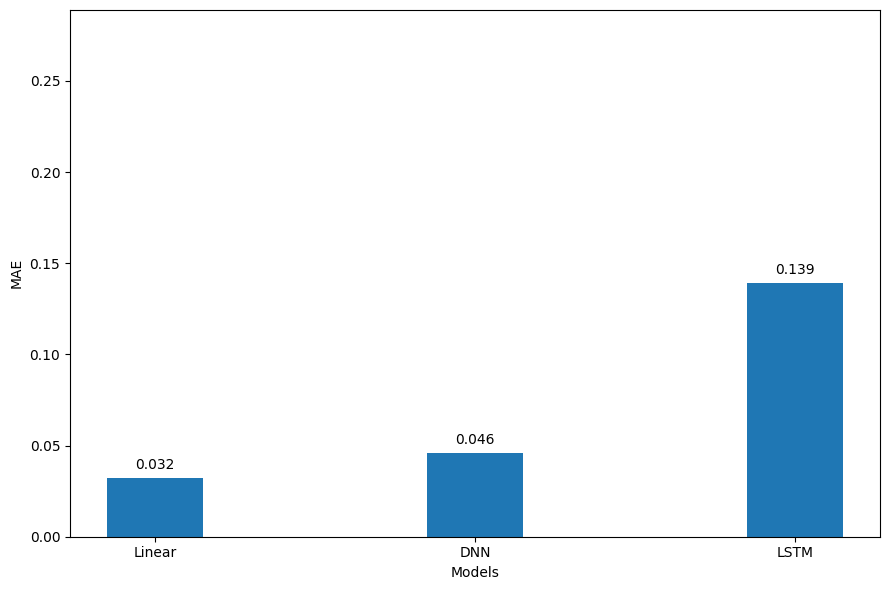

In [15]:
model_list = ['Linear', 'DNN', 'LSTM']

ss_mae = [0.032, 0.046]
ss_mae.append(ss_lstm.evaluate(test_ds_ss)[1])

plot_evaluation(model_list, ss_mae)

## Multi-step model 

In [16]:
train_ds_ms = format_timeseries_data(train_df, 24, 24, ['OT'])
val_ds_ms = format_timeseries_data(val_df, 24, 24, ['OT'])
test_ds_ms = format_timeseries_data(test_df, 24, 24, ['OT'])

ms_sample_batch = next(iter(test_ds_ms))

In [20]:
# Create a multi-step LSTM model
ms_lstm = Sequential([
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=True),
    Dense(1)
])

ms_lstm_history = train_model(ms_lstm, train_ds_ms, val_ds_ms, use_scheduler=True)

Epoch 1/50


380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0471 - mean_absolute_error: 0.1384 - val_loss: 0.0117 - val_mean_absolute_error: 0.0923 - learning_rate: 0.0010
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0198 - mean_absolute_error: 0.0966 - val_loss: 0.0224 - val_mean_absolute_error: 0.1360 - learning_rate: 0.0010
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0193 - mean_absolute_error: 0.1000 - val_loss: 0.0273 - val_mean_absolute_error: 0.1459 - learning_rate: 9.0484e-04
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0151 - mean_absolute_error: 0.0943 - val_loss: 0.0221 - val_mean_absolute_error: 0.1142 - learning_rate: 8.1873e-04
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0110 - mean_absolute_error: 0.0835 - val_loss: 0.0046 - val_mean_absolute_error: 0.0518 - learning_rate: 7.4082e-04
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0101 - mean_absolute_error: 0.0802 - val_loss: 0.0133 - val_m

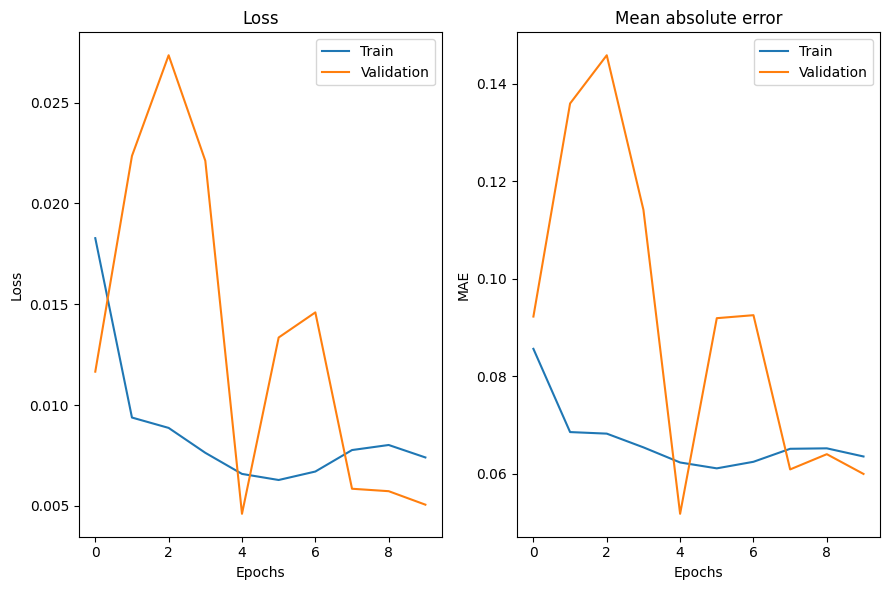

In [21]:
plot_history(ms_lstm_history)

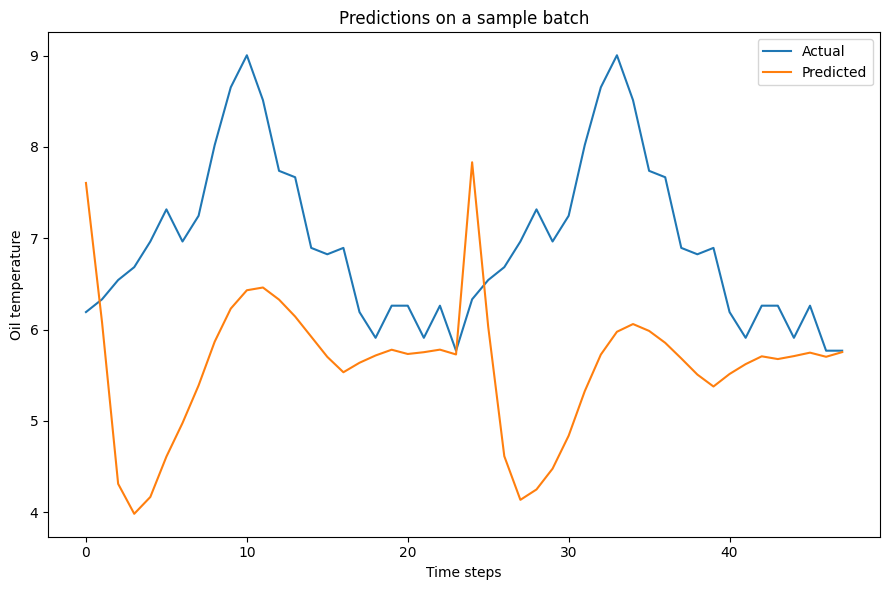

In [22]:
plot_predictions(ms_lstm, ms_sample_batch, 'multi_step')

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0879 - mean_absolute_error: 0.2553


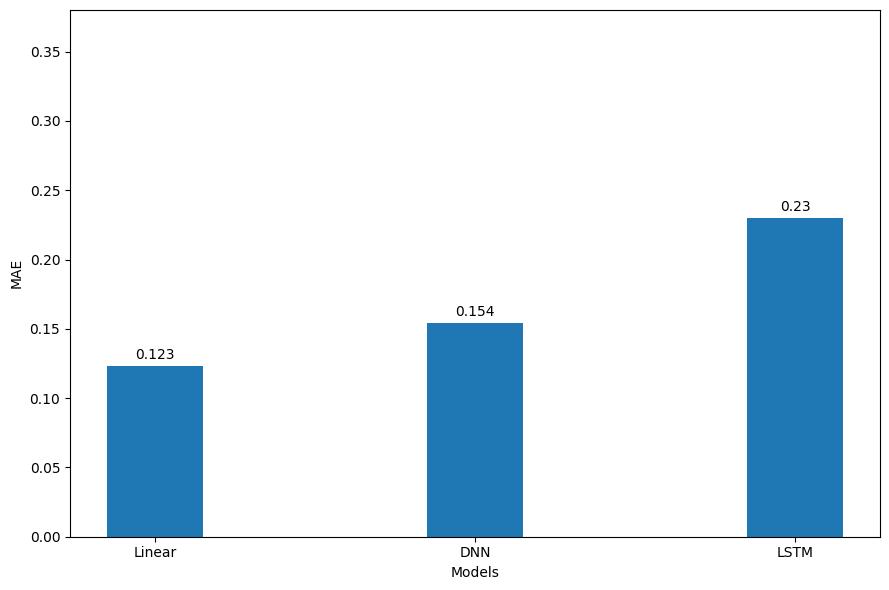

In [23]:
ms_mae = [0.123, 0.154]
ms_mae.append(ms_lstm.evaluate(test_ds_ms)[1])

plot_evaluation(model_list, ms_mae)

## Multi-output model 

In [24]:
train_ds_mo = format_timeseries_data(train_df, 1, 1, ['OT', 'MULL'])
val_ds_mo = format_timeseries_data(val_df, 1, 1, ['OT', 'MULL'])
test_ds_mo = format_timeseries_data(test_df, 1, 1, ['OT', 'MULL'])

mo_sample_batch = next(iter(test_ds_mo))

In [25]:
# Create a multi-output LSTM model
mo_lstm = Sequential([
    LSTM(32, return_sequences=True),
    Dense(2)
])

mo_lstm_history = train_model(mo_lstm, train_ds_mo, val_ds_mo)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0975 - mean_absolute_error: 0.2178 - val_loss: 0.0146 - val_mean_absolute_error: 0.0907
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - mean_absolute_error: 0.0798 - val_loss: 0.0052 - val_mean_absolute_error: 0.0526
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0704 - val_loss: 0.0029 - val_mean_absolute_error: 0.0410
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062 - mean_absolute_error: 0.0599 - val_loss: 0.0035 - val_mean_absolute_error: 0.0457
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0603 - val_loss: 0.0043 - val_mean_absolute_error: 0.0526
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0062 - mean_absolute_error: 0.0599 - val_loss: 0.0051 - val_mean_absolute_error: 0.0578
Epoch 7/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - mean_absolute_error: 0.0576 - v

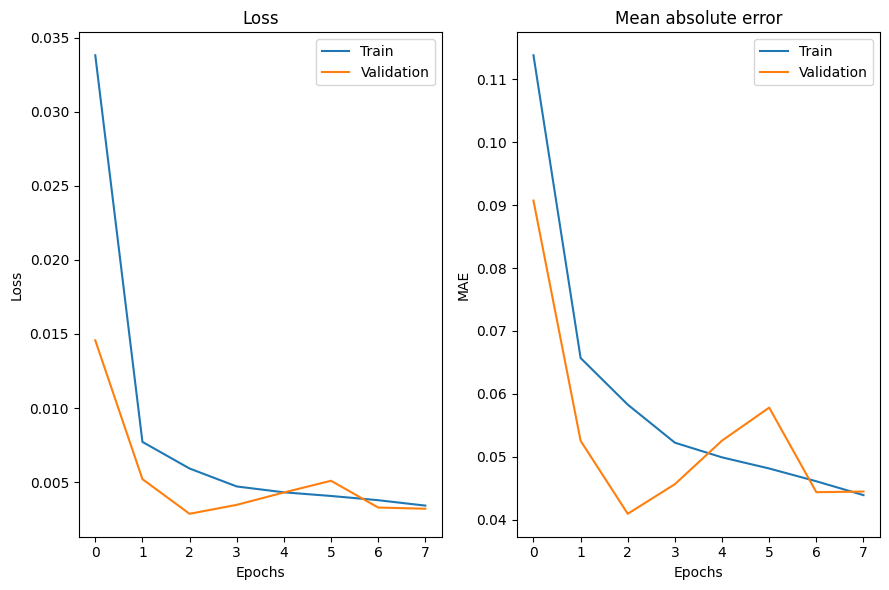

In [26]:
plot_history(mo_lstm_history)

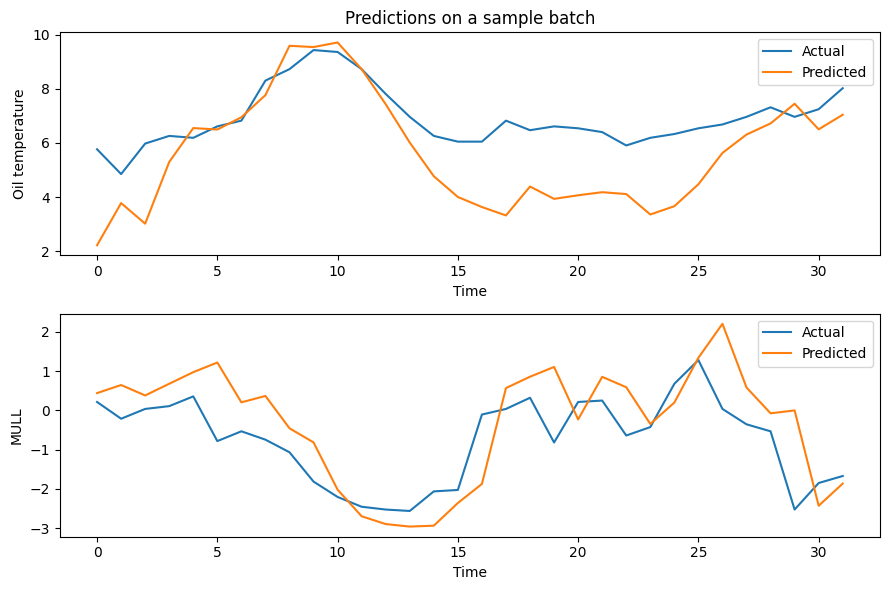

In [27]:
plot_predictions(mo_lstm, mo_sample_batch, 'multi_output')

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.1250


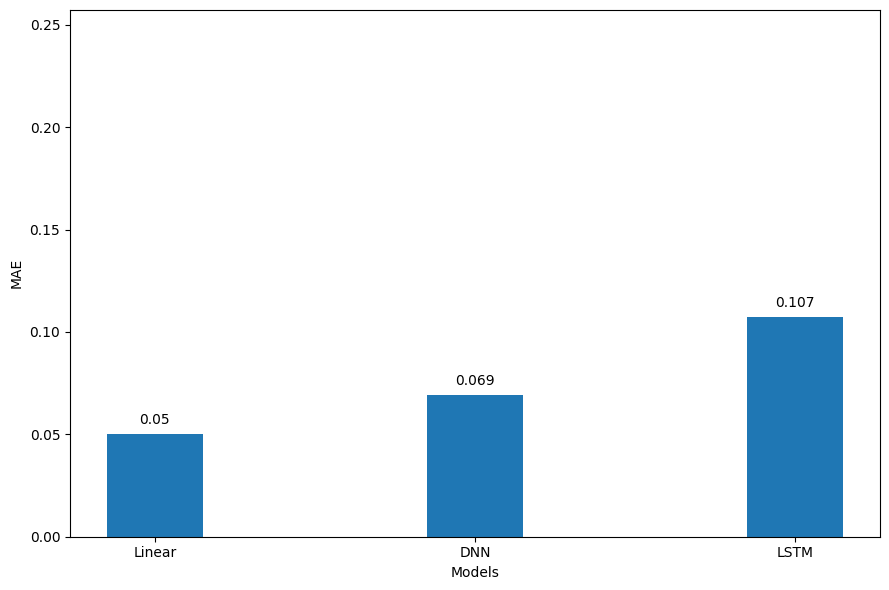

In [28]:
mo_mae = [0.05, 0.069]
mo_mae.append(mo_lstm.evaluate(test_ds_mo)[1])

plot_evaluation(model_list, mo_mae)